In [1]:
!pip install selenium pandas sqlalchemy sqlite-utils tqdm requests python-dotenv
!pip install pymysql
!pip install jupyter matplotlib plotly seaborn


In [2]:
!python -m venv .venv/bin/activate

In [3]:
import os, time, re, urllib.parse
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

BASE_URL = "https://cricsheet.org/matches/"
DOWNLOAD_DIR = Path("data_raw").resolve()
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

FORMATS = {"Test", "ODI", "T20", "IPL"}  

def main():
    opts = Options()
    opts.add_argument("--headless=new")
    driver = webdriver.Chrome(options=opts)
    driver.get(BASE_URL)

    wait = WebDriverWait(driver, 20)

    # Example: collect all links ending in .json or .zip (site may provide either)
    links = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'a[href]')))
    to_download = []
    for a in links:
        href = a.get_attribute("href") or ""
        text = (a.text or "").strip()
        if href.endswith(".json") or href.endswith(".zip"):
            # keep only if the anchor text or surrounding context mentions formats you want
            for f in FORMATS:
                if f.lower() in text.lower() or f.lower() in href.lower():
                    to_download.append(href)
                    break

    to_download = sorted(set(to_download))
    print(f"Found {len(to_download)} files to download")

    # Use Selenium click (if needed) or fallback to requests (faster).
    import requests
    for url in to_download:
        fname = urllib.parse.unquote(url.split("/")[-1])
        out = DOWNLOAD_DIR / fname
        if out.exists(): 
            continue
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        out.write_bytes(r.content)
        print("Saved:", out)

    driver.quit()

if __name__ == "__main__":
    main()


Found 10 files to download


In [5]:
def flatten_match(json_obj, match_id_hint):
    info = json_obj.get("info", {})
    outcome = info.get("outcome", {}) if isinstance(info.get("outcome", {}), dict) else {}
    by = outcome.get("by", {}) if isinstance(outcome, dict) else {}

    winner = outcome.get("winner") if isinstance(outcome, dict) else None
    dates = info.get("dates") or []
    match_date = str(dates[0]) if dates else None

    rec_match = {
        "match_id": match_id_hint,
        "match_type": info.get("match_type"),
        "date": match_date,
        "city": info.get("city"),
        "venue": info.get("venue"),
        "team1": (info.get("teams") or [None, None])[0],
        "team2": (info.get("teams") or [None, None])[1],
        "toss_winner": (info.get("toss") or {}).get("winner"),
        "toss_decision": (info.get("toss") or {}).get("decision"),
        "winner": winner,
        "win_by_runs": by.get("runs"),
        "win_by_wickets": by.get("wickets"),
    }

    deliv_rows = []
    innings_list = json_obj.get("innings") or []

    for inn_ix, inn in enumerate(innings_list, start=1):
        # Case A: { "1st innings": {...} }
        if isinstance(inn, dict) and len(inn) == 1 and isinstance(next(iter(inn.values())), dict):
            inn_dict = next(iter(inn.values()))
        # Case B: already { "team": ..., "overs": [...] }
        elif isinstance(inn, dict) and "overs" in inn:
            inn_dict = inn
        else:
            skipped.append((match_id_hint, inn_ix, f"Unexpected innings type: {type(inn).__name__}"))
            continue

        batting_team = inn_dict.get("team")
        if not batting_team:
            skipped.append((match_id_hint, inn_ix, "missing team"))
            continue

        for over in inn_dict.get("overs", []):
            over_no = over.get("over")
            for d in over.get("deliveries", []):
                runs = d.get("runs", {})
                wickets = d.get("wickets", []) or []
                wicket_kind = wickets[0].get("kind") if wickets else None
                player_out = wickets[0].get("player_out") if wickets else None

                deliv_rows.append({
                    "match_id": rec_match["match_id"],
                    "innings_no": inn_ix,
                    "over_no": over_no,
                    "ball_in_over": d.get("ball"),
                    "batting_team": batting_team,
                    "bowling_team": d.get("bowling_team"),
                    "striker": d.get("batter"),
                    "non_striker": d.get("non_striker"),
                    "bowler": d.get("bowler"),
                    "runs_batter": runs.get("batter", 0),
                    "runs_extras": runs.get("extras", 0),
                    "runs_total": runs.get("total", 0),
                    "wicket_kind": wicket_kind,
                    "player_out": player_out,
                    "is_boundary_4": 1 if runs.get("batter", 0) == 4 else 0,
                    "is_boundary_6": 1 if runs.get("batter", 0) == 6 else 0,
                })

    return rec_match, deliv_rows


In [6]:
import json, zipfile
from pathlib import Path

RAW = Path("data_raw")

def iter_json_files():
    for p in RAW.glob("*.json"):
        yield p.name, p.read_bytes()
    for zpath in RAW.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as z:
            for name in z.namelist():
                if name.endswith(".json"):
                    yield name, z.read(name)

for name, blob in iter_json_files():
    js = json.loads(blob.decode("utf-8", errors="ignore"))
    print("File:", name)
    print("Innings field:")
    print(js.get("innings"))
    break 


➡ File: 1082591.json
➡ Innings field:
[{'team': 'Sunrisers Hyderabad', 'overs': [{'over': 0, 'deliveries': [{'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 4, 'extras': 0, 'total': 4}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'extras': {'wides': 2}, 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 2, 'total': 2}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'extras': {'legbyes': 1}, 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 1, 't

In [7]:
import json, zipfile
from pathlib import Path
import pandas as pd
from tqdm import tqdm

RAW = Path("data_raw")
PARSED = Path("data_parsed")
PARSED.mkdir(exist_ok=True)

skipped = []


def flatten_match(json_obj, match_id_hint):
    info = json_obj.get("info", {})
    outcome = info.get("outcome", {}) if isinstance(info.get("outcome", {}), dict) else {}
    by = outcome.get("by", {}) if isinstance(outcome, dict) else {}

    winner = outcome.get("winner") if isinstance(outcome, dict) else None
    dates = info.get("dates") or []
    match_date = str(dates[0]) if dates else None

    rec_match = {
        "match_id": match_id_hint,
        "match_type": info.get("match_type"),
        "date": match_date,
        "city": info.get("city"),
        "venue": info.get("venue"),
        "team1": (info.get("teams") or [None, None])[0],
        "team2": (info.get("teams") or [None, None])[1],
        "toss_winner": (info.get("toss") or {}).get("winner"),
        "toss_decision": (info.get("toss") or {}).get("decision"),
        "winner": winner,
        "win_by_runs": by.get("runs"),
        "win_by_wickets": by.get("wickets"),
    }

    deliv_rows = []
    innings_list = json_obj.get("innings") or []

    for inn_ix, inn in enumerate(innings_list, start=1):

        # Case A: { "1st innings": {...} }
        if isinstance(inn, dict) and len(inn) == 1 and isinstance(next(iter(inn.values())), dict):
            inn_dict = next(iter(inn.values()))

        # Case B: already {"team": ..., "overs": [...]}
        elif isinstance(inn, dict) and "overs" in inn:
            inn_dict = inn

        # Case C: weird → skip
        else:
            skipped.append((match_id_hint, inn_ix, f"Unexpected innings type: {inn}"))
            continue

        batting_team = inn_dict.get("team")
        if not batting_team:
            skipped.append((match_id_hint, inn_ix, "Missing team"))
            continue

        for over in inn_dict.get("overs", []):
            over_no = over.get("over")
            for d in over.get("deliveries", []):
                runs = d.get("runs", {})
                wickets = d.get("wickets", []) or []
                wicket_kind = wickets[0].get("kind") if wickets else None
                player_out = wickets[0].get("player_out") if wickets else None

                deliv_rows.append({
                    "match_id": rec_match["match_id"],
                    "innings_no": inn_ix,
                    "over_no": over_no,
                    "ball_in_over": d.get("ball"),
                    "batting_team": batting_team,
                    "bowling_team": d.get("bowling_team"),
                    "striker": d.get("batter"),
                    "non_striker": d.get("non_striker"),
                    "bowler": d.get("bowler"),
                    "runs_batter": runs.get("batter", 0),
                    "runs_extras": runs.get("extras", 0),
                    "runs_total": runs.get("total", 0),
                    "wicket_kind": wicket_kind,
                    "player_out": player_out,
                    "is_boundary_4": 1 if runs.get("batter", 0) == 4 else 0,
                    "is_boundary_6": 1 if runs.get("batter", 0) == 6 else 0,
                })

    return rec_match, deliv_rows


def iter_json_files():
    for p in RAW.glob("*.json"):
        yield p.name, p.read_bytes()
    for zpath in RAW.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as z:
            for name in z.namelist():
                if name.endswith(".json"):
                    yield name, z.read(name)


def main():
    matches_rows, deliveries_rows = [], []

    for name, blob in tqdm(list(iter_json_files())):
        try:
            js = json.loads(blob.decode("utf-8"))
        except UnicodeDecodeError:
            js = json.loads(blob.decode("latin-1"))

        match_id = Path(name).stem
        rec, delivs = flatten_match(js, match_id)
        matches_rows.append(rec)
        deliveries_rows.extend(delivs)

    df_matches = pd.DataFrame(matches_rows)
    df_deliveries = pd.DataFrame(deliveries_rows)

    df_matches.to_parquet(PARSED / "matches.parquet", index=False)
    df_deliveries.to_parquet(PARSED / "deliveries.parquet", index=False)

    # summary
    print(f"[INFO] Parsed {len(df_matches)} matches, {len(df_deliveries)} deliveries")
    if skipped:
        df_skipped = pd.DataFrame(skipped, columns=["match_id", "innings_no", "reason"])
        df_skipped.to_csv(PARSED / "skipped_matches.csv", index=False)
        print(f"[INFO] {len(skipped)} innings skipped. See skipped_matches.csv")
    else:
        print("[INFO] No innings skipped.")

    print("Saved parsed parquet files.")


if __name__ == "__main__":
    main()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9856/9856 [01:10<00:00, 140.73it/s]


[INFO] Parsed 9856 matches, 4648874 deliveries
[INFO] No innings skipped.
✅ Saved parsed parquet files.


In [8]:
import pandas as pd
from pathlib import Path
from sqlalchemy import create_engine, text

PARSED = Path("data_parsed")

df_matches = pd.read_parquet(PARSED / "matches.parquet")
df_deliveries = pd.read_parquet(PARSED / "deliveries.parquet")

engine = create_engine("sqlite:///cricsheet.db", echo=False)

with engine.begin() as conn:
   
    conn.exec_driver_sql("DROP TABLE IF EXISTS deliveries;")
    conn.exec_driver_sql("DROP TABLE IF EXISTS matches;")

   
    conn.exec_driver_sql("""
    CREATE TABLE matches (
      match_id TEXT PRIMARY KEY,
      match_type TEXT,
      date TEXT,
      city TEXT,
      venue TEXT,
      team1 TEXT, team2 TEXT,
      toss_winner TEXT, toss_decision TEXT,
      winner TEXT,
      win_by_runs INTEGER,
      win_by_wickets INTEGER
    );
    """)
    conn.exec_driver_sql("""
    CREATE TABLE deliveries (
      match_id TEXT,
      innings_no INTEGER,
      over_no INTEGER,
      ball_in_over REAL,
      batting_team TEXT,
      bowling_team TEXT,
      striker TEXT,
      non_striker TEXT,
      bowler TEXT,
      runs_batter INTEGER,
      runs_extras INTEGER,
      runs_total INTEGER,
      wicket_kind TEXT,
      player_out TEXT,
      is_boundary_4 INTEGER,
      is_boundary_6 INTEGER,
      FOREIGN KEY(match_id) REFERENCES matches(match_id)
    );
    """)

df_matches.to_sql("matches", con=engine, if_exists="append", index=False)
df_deliveries.to_sql("deliveries", con=engine, if_exists="append", index=False)

# Indexes speed up analysis
with engine.begin() as conn:
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_match ON deliveries(match_id);")
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_bats ON deliveries(striker);")
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_bowl ON deliveries(bowler);")

print("Loaded into cricsheet.db")


Loaded into cricsheet.db


In [13]:
from sqlalchemy import create_engine
import pandas as pd

# SQLite engine
engine = create_engine("sqlite:///cricsheet.db")


In [14]:
# 1. Top 10 ODI run-scorers
q1 = """
SELECT striker AS batsman, SUM(runs_batter) AS runs
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY runs DESC
LIMIT 10;
"""
pd.read_sql(q1, engine)



,batsman,runs
0,V Kohli,14059
1,KC Sangakkara,11618
2,RG Sharma,10948
3,MS Dhoni,10274
4,AB de Villiers,9435
5,TM Dilshan,9212
6,LRPL Taylor,8126
7,DPMD Jayawardene,8040
8,HM Amla,7834
9,Tamim Iqbal,7648


In [15]:
# 2. Top 10 T20 wicket-takers
q2 = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type = 'T20' AND wicket_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;
"""
pd.read_sql(q2, engine)


,bowler,wickets
0,YS Chahal,329
1,SL Malinga,312
2,B Kumar,305
3,DJ Bravo,300
4,JJ Bumrah,295
5,R Ashwin,277
6,SP Narine,263
7,RA Jadeja,235
8,TG Southee,232
9,TA Boult,229


In [16]:
# 3. Team with highest Test win % (min 10 matches)
q3 = """
WITH team_matches AS (
  SELECT team1 AS team, COUNT(*) AS played FROM matches WHERE match_type='Test'
  GROUP BY team1
  UNION ALL
  SELECT team2 AS team, COUNT(*) AS played FROM matches WHERE match_type='Test'
  GROUP BY team2
),
agg AS (
  SELECT team, SUM(played) AS played
  FROM team_matches GROUP BY team
),
wins AS (
  SELECT winner AS team, COUNT(*) AS wins
  FROM matches WHERE match_type='Test' AND winner IS NOT NULL
  GROUP BY winner
)
SELECT a.team,
       COALESCE(w.wins,0) * 1.0 / a.played AS win_pct,
       a.played, COALESCE(w.wins,0) AS wins
FROM agg a LEFT JOIN wins w ON a.team=w.team
WHERE a.played >= 10
ORDER BY win_pct DESC;
"""
pd.read_sql(q3, engine)


,team,win_pct,played,wins
0,Australia,0.551282,234,129
1,South Africa,0.505208,192,97
2,India,0.481818,220,106
3,England,0.427046,281,120
4,New Zealand,0.397516,161,64
5,Sri Lanka,0.385057,174,67
6,Pakistan,0.354839,155,55
7,West Indies,0.225610,164,37
8,Bangladesh,0.177966,118,21
9,Zimbabwe,0.104167,48,5


In [17]:
# 4. Total number of centuries across all formats
q4 = """
WITH batter_innings AS (
  SELECT match_id, innings_no, striker, SUM(runs_batter) AS runs
  FROM deliveries
  GROUP BY match_id, innings_no, striker
)
SELECT COUNT(*) AS centuries
FROM batter_innings
WHERE runs >= 100;
"""
pd.read_sql(q4, engine)


,centuries
0,3586


In [18]:
# 5. Matches with narrowest victory (by runs)
q5 = """
SELECT match_id, winner, win_by_runs
FROM matches
WHERE win_by_runs IS NOT NULL
ORDER BY win_by_runs ASC
LIMIT 10;
"""
pd.read_sql(q5, engine)


,match_id,winner,win_by_runs
0,1082650,Mumbai Indians,1
1,1178414,Royal Challengers Bangalore,1
2,1181768,Mumbai Indians,1
3,1254079,Royal Challengers Bangalore,1
4,1359542,Lucknow Super Giants,1
5,1426274,Kolkata Knight Riders,1
6,1426288,Sunrisers Hyderabad,1
7,336028,Kings XI Punjab,1
8,392229,Kings XI Punjab,1
9,548345,Delhi Daredevils,1


In [19]:
# 6. Most fours in ODI
q6 = """
SELECT striker, SUM(is_boundary_4) AS fours
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='ODI'
GROUP BY striker
ORDER BY fours DESC
LIMIT 10;
"""
pd.read_sql(q6, engine)


,striker,fours
0,V Kohli,1315
1,KC Sangakkara,1120
2,RG Sharma,1024
3,TM Dilshan,1022
4,Tamim Iqbal,841
5,S Dhawan,838
6,AB de Villiers,825
7,HM Amla,796
8,MS Dhoni,787
9,SR Tendulkar,774


In [20]:
# 7. Most sixes in T20
q7 = """
SELECT striker, SUM(is_boundary_6) AS sixes
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='T20'
GROUP BY striker
ORDER BY sixes DESC
LIMIT 10;
"""
pd.read_sql(q7, engine)


,striker,sixes
0,RG Sharma,499
1,CH Gayle,487
2,V Kohli,407
3,DA Warner,358
4,JC Buttler,345
5,KA Pollard,322
6,AD Russell,318
7,MS Dhoni,313
8,SA Yadav,310
9,N Pooran,308


In [21]:
# 8. Best bowling economy in T20 (min 100 balls)
q8 = """
WITH bowl AS (
  SELECT bowler,
         COUNT(*) AS balls,
         SUM(runs_total) AS runs
  FROM deliveries d JOIN matches m USING(match_id)
  WHERE m.match_type='T20'
  GROUP BY bowler
)
SELECT bowler, runs * 6.0 / NULLIF(balls,0) AS economy, balls
FROM bowl
WHERE balls >= 100
ORDER BY economy ASC
LIMIT 10;
"""
pd.read_sql(q8, engine)


,bowler,economy,balls
0,NKD Murtiari,1.247525,101
1,SI Bara,1.651007,149
2,S Namusha,2.285714,126
3,Meghna Rajan,2.319018,163
4,T Granger,2.563107,103
5,SAN Maypriani,2.687500,288
6,I Chathurani,2.692683,205
7,DAL Paramitha,2.743719,199
8,N Caruana,2.844828,116
9,A Dirannehelage,2.883495,206


In [22]:
# 9. Best batting strike rate in ODI (min 300 balls)
q9 = """
WITH bat AS (
  SELECT striker AS batter,
         COUNT(*) AS balls,
         SUM(runs_batter) AS runs
  FROM deliveries d JOIN matches m USING(match_id)
  WHERE m.match_type='ODI'
  GROUP BY striker
)
SELECT batter, runs * 100.0 / NULLIF(balls,0) AS strike_rate, runs, balls
FROM bat
WHERE balls >= 300
ORDER BY strike_rate DESC
LIMIT 10;
"""
pd.read_sql(q9, engine)


,batter,strike_rate,runs,balls
0,Shahid Afridi,131.001004,3913,2987
1,AD Russell,128.447205,1034,805
2,GJ Maxwell,120.988867,3695,3054
3,Asif Ali,118.296530,375,317
4,H Klaasen,115.878195,2131,1839
5,Hasan Ali,113.897281,377,331
6,Sharjeel Khan,113.728324,787,692
7,JC Buttler,113.566312,5232,4607
8,PD Salt,113.356562,976,861
9,JM Davison,112.722646,443,393


In [23]:
# 10. Toss impact: win % when winning toss
q10 = """
WITH t AS (
  SELECT match_id,
         CASE WHEN winner = toss_winner THEN 1 ELSE 0 END AS won_after_toss_win
  FROM matches WHERE winner IS NOT NULL
)
SELECT AVG(won_after_toss_win) AS win_pct_after_toss_win
FROM t;
"""
pd.read_sql(q10, engine)


,win_pct_after_toss_win
0,0.507999


In [24]:
# 11. Chasing vs batting first win %
q11 = """
SELECT
  AVG(CASE WHEN win_by_wickets IS NOT NULL THEN 1.0 ELSE NULL END) AS pct_chases_won,
  AVG(CASE WHEN win_by_runs IS NOT NULL THEN 1.0 ELSE NULL END) AS pct_defends_won
FROM matches
WHERE winner IS NOT NULL;
"""
pd.read_sql(q11, engine)


,pct_chases_won,pct_defends_won
0,1.0,1.0


In [25]:
# 12. Venue with most matches
q12 = """
SELECT venue, COUNT(*) AS matches
FROM matches
GROUP BY venue
ORDER BY matches DESC
LIMIT 10;
"""
pd.read_sql(q12, engine)


,venue,matches
0,Dubai International Cricket Stadium,214
1,Harare Sports Club,198
2,Shere Bangla National Stadium,136
3,Sheikh Zayed Stadium,131
4,Al Amerat Cricket Ground Oman Cricket (Ministr...,129
5,Sharjah Cricket Stadium,111
6,Eden Gardens,103
7,Wankhede Stadium,97
8,Sydney Cricket Ground,94
9,M Chinnaswamy Stadium,91


In [26]:
# 13. Top partnerships (approx)
q13 = """
SELECT match_id, innings_no, striker, non_striker, SUM(runs_batter) AS runs
FROM deliveries
GROUP BY match_id, innings_no, striker, non_striker
ORDER BY runs DESC
LIMIT 10;
"""
pd.read_sql(q13, engine)


,match_id,innings_no,striker,non_striker,runs
0,249193,2,DPMD Jayawardene,KC Sangakkara,309
1,249193,2,KC Sangakkara,DPMD Jayawardene,285
2,1442215,2,HC Brook,JE Root,260
3,892515,1,AC Voges,SE Marsh,249
4,800463,1,BA Stokes,JM Bairstow,234
5,323948,1,GC Smith,ND McKenzie,232
6,388993,1,TT Samaraweera,DPMD Jayawardene,231
7,656427,1,CH Gayle,MN Samuels,215
8,518953,1,MJ Clarke,RT Ponting,210
9,667653,3,BB McCullum,BJ Watling,210


In [27]:
# 14. Powerplay runs (overs 1–6) in T20
q14 = """
SELECT match_id, innings_no, SUM(runs_total) AS pp_runs
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='T20' AND over_no BETWEEN 1 AND 6
GROUP BY match_id, innings_no
ORDER BY pp_runs DESC
LIMIT 10;
"""
pd.read_sql(q14, engine)


,match_id,innings_no,pp_runs
0,1426295,2,118
1,1440463,2,118
2,1426273,1,114
3,1491608,1,113
4,1402765,1,106
5,1453922,1,106
6,1453932,1,104
7,1482830,1,104
8,1490885,2,104
9,1339605,2,102


In [28]:
# 15. Death overs economy (16–20) in T20
q15 = """
WITH death AS (
  SELECT bowler, COUNT(*) AS balls, SUM(runs_total) AS runs
  FROM deliveries d JOIN matches m USING(match_id)
  WHERE m.match_type='T20' AND over_no BETWEEN 16 AND 20
  GROUP BY bowler
)
SELECT bowler, runs * 6.0 / NULLIF(balls,0) AS economy, balls
FROM death
WHERE balls >= 60
ORDER BY economy ASC
LIMIT 10;
"""
pd.read_sql(q15, engine)


,bowler,economy,balls
0,D Koralalage,3.194805,77
1,Rosine Irera,3.441860,129
2,Mas Elysa,3.636364,99
3,CM Greechan,3.910112,89
4,AI Chudasama,4.031250,64
5,S Kato,4.087912,91
6,F Overdijk,4.094118,85
7,M Hill,4.220930,172
8,ZT Kyaw,4.260870,69
9,KA Green,4.329897,97


In [29]:
# 16. Most wickets at a venue
q16 = """
SELECT bowler, venue, COUNT(*) AS wickets
FROM deliveries d
JOIN matches m USING(match_id)
WHERE wicket_kind IS NOT NULL
GROUP BY bowler, venue
ORDER BY wickets DESC
LIMIT 10;
"""
pd.read_sql(q16, engine)


,bowler,venue,wickets
0,Shakib Al Hasan,Shere Bangla National Stadium,151
1,JM Anderson,Lord's,117
2,SCJ Broad,Lord's,111
3,HMRKB Herath,Galle International Stadium,101
4,DW Steyn,Newlands,94
5,DW Steyn,SuperSport Park,92
6,NGRP Jayasuriya,Galle International Stadium,85
7,Abdur Razzak,Shere Bangla National Stadium,80
8,TG Southee,Seddon Park,80
9,HMRKB Herath,Sinhalese Sports Club Ground,79


In [30]:
# 17. Centuries by player
q17 = """
WITH batter_innings AS (
  SELECT match_id, innings_no, striker, SUM(runs_batter) AS runs
  FROM deliveries
  GROUP BY match_id, innings_no, striker
)
SELECT striker AS batter, COUNT(*) AS hundreds
FROM batter_innings
WHERE runs >= 100
GROUP BY striker
ORDER BY hundreds DESC
LIMIT 10;
"""
pd.read_sql(q17, engine)


,batter,hundreds
0,V Kohli,89
1,JE Root,56
2,HM Amla,56
3,KC Sangakkara,53
4,DA Warner,52
5,SPD Smith,49
6,RG Sharma,49
7,AB de Villiers,49
8,KS Williamson,48
9,LRPL Taylor,39


In [31]:
# 18. Most dismissals by type
q18 = """
SELECT wicket_kind, COUNT(*) AS cnt
FROM deliveries
WHERE wicket_kind IS NOT NULL
GROUP BY wicket_kind
ORDER BY cnt DESC;
"""
pd.read_sql(q18, engine)


,wicket_kind,cnt
0,caught,79669
1,bowled,29593
2,lbw,15776
3,run out,11576
4,stumped,4471
5,caught and bowled,4438
6,retired hurt,197
7,hit wicket,123
8,retired out,25
9,obstructing the field,17


In [32]:
# 19. Most 50+ scores
q19 = """
WITH batter_innings AS (
  SELECT match_id, innings_no, striker, SUM(runs_batter) AS runs
  FROM deliveries
  GROUP BY match_id, innings_no, striker
)
SELECT striker AS batter, COUNT(*) AS fifties_plus
FROM batter_innings
WHERE runs BETWEEN 50 AND 99
GROUP BY striker
ORDER BY fifties_plus DESC
LIMIT 10;
"""
pd.read_sql(q19, engine)


,batter,fifties_plus
0,V Kohli,203
1,DA Warner,159
2,RG Sharma,153
3,AB de Villiers,143
4,MS Dhoni,129
5,KC Sangakkara,127
6,KS Williamson,119
7,JE Root,112
8,S Dhawan,105
9,F du Plessis,104


In [33]:
# 20. Team head-to-head wins
q20 = """
SELECT winner AS team, COUNT(*) AS wins
FROM matches
WHERE winner IS NOT NULL
GROUP BY winner
ORDER BY wins DESC;
"""
pd.read_sql(q20, engine)


,team,wins
0,Australia,737
1,India,719
2,England,649
3,South Africa,559
4,New Zealand,489
...,...,...
116,Slovenia,1
117,ICC World XI,1
118,Gambia,1
119,Barbados,1


In [38]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [39]:
# DB Connection
engine = create_engine("sqlite:///cricsheet.db")

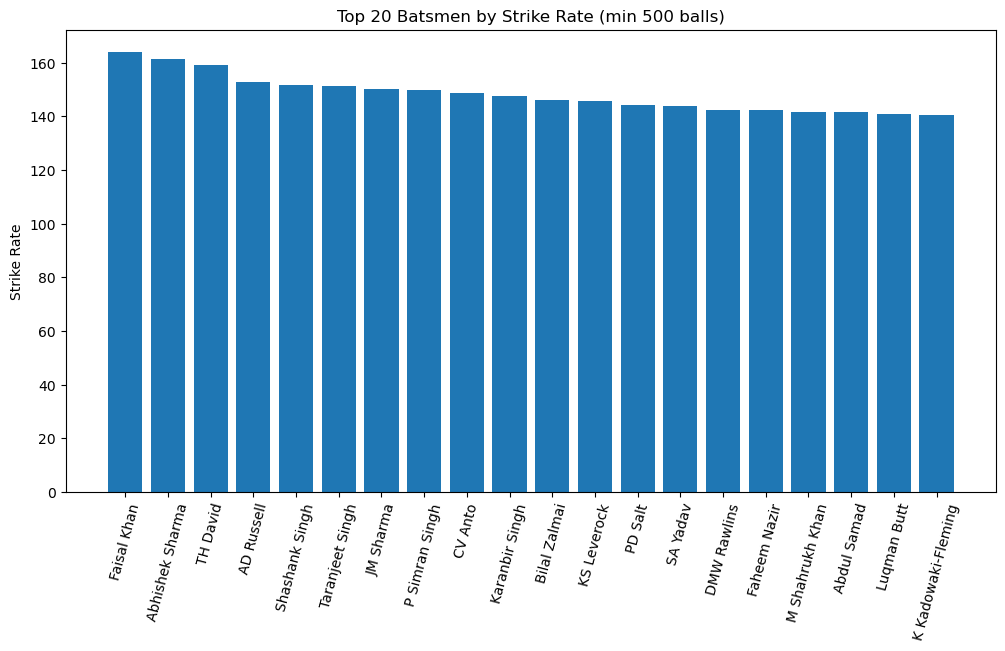

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\3078344935.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




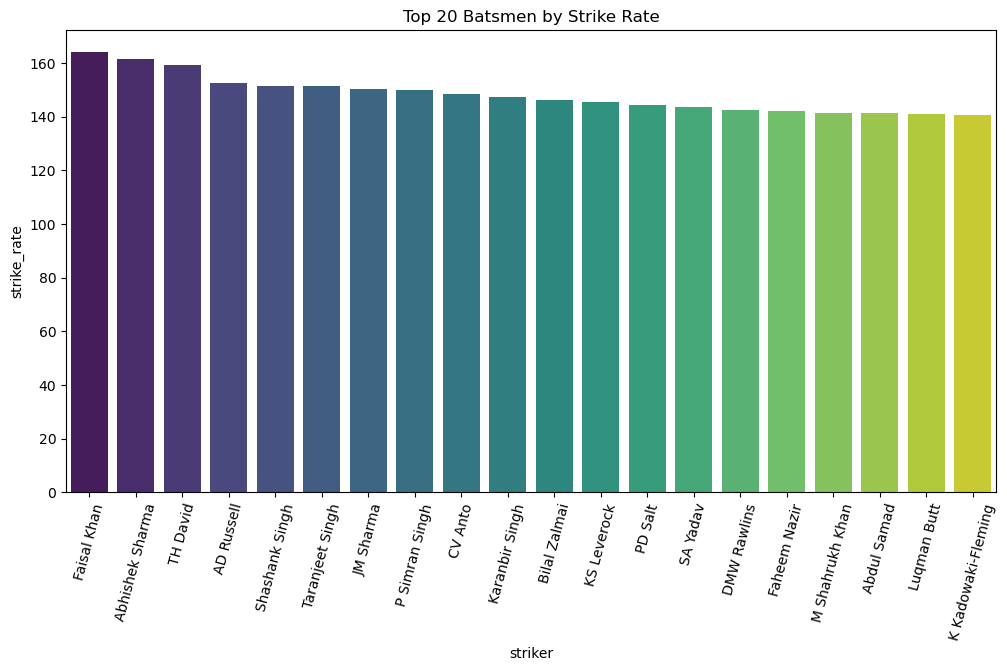

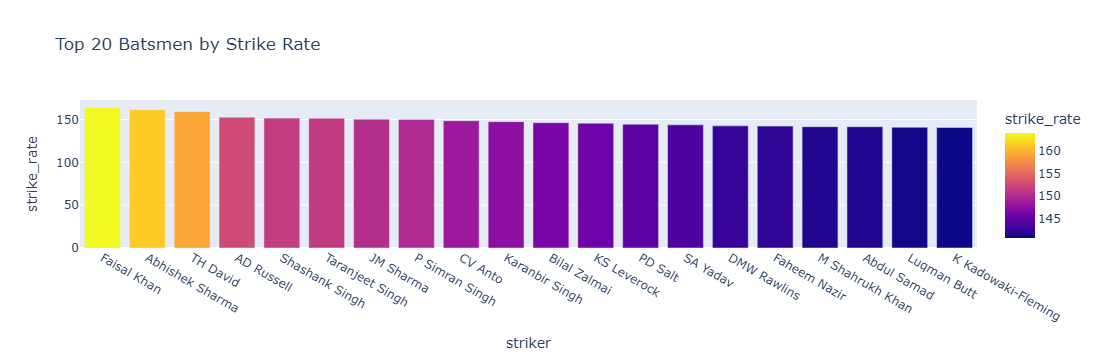

In [58]:
query1 = """
SELECT striker, 
       SUM(runs_batter) * 100.0 / COUNT(*) AS strike_rate,
       COUNT(*) AS balls
FROM deliveries
GROUP BY striker
HAVING balls >= 500
ORDER BY strike_rate DESC
LIMIT 20;
"""
df = pd.read_sql(query1, engine)

# Matplotlib
plt.figure(figsize=(12,6))
plt.bar(df['striker'], df['strike_rate'])
plt.xticks(rotation=75)
plt.ylabel("Strike Rate")
plt.title("Top 20 Batsmen by Strike Rate (min 500 balls)")
plt.show()

# Seaborn
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="striker", y="strike_rate", palette="viridis")
plt.xticks(rotation=75)
plt.title("Top 20 Batsmen by Strike Rate")
plt.show()

# Plotly
px.bar(df, x="striker", y="strike_rate", title="Top 20 Batsmen by Strike Rate", 
       hover_data=["balls"], color="strike_rate")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\672280655.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




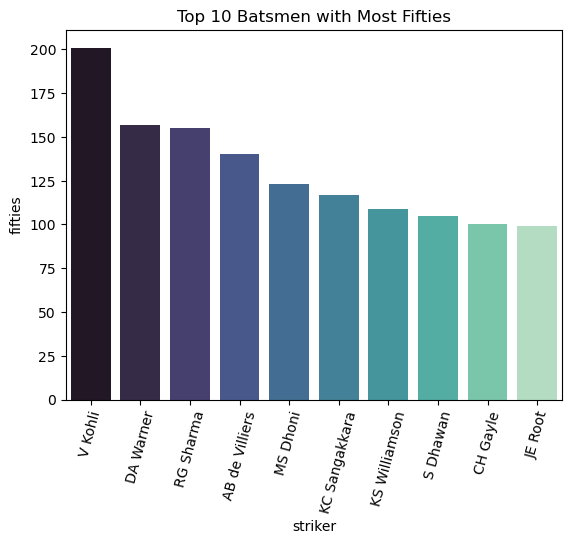

In [59]:
query2 = """
SELECT striker, COUNT(*) AS fifties
FROM (
    SELECT match_id, striker, SUM(runs_batter) AS runs
    FROM deliveries
    GROUP BY match_id, striker
    HAVING runs BETWEEN 50 AND 99
)
GROUP BY striker
ORDER BY fifties DESC
LIMIT 10;
"""
df = pd.read_sql(query2, engine)

sns.barplot(data=df, x="striker", y="fifties", palette="mako")
plt.xticks(rotation=75)
plt.title("Top 10 Batsmen with Most Fifties")
plt.show()


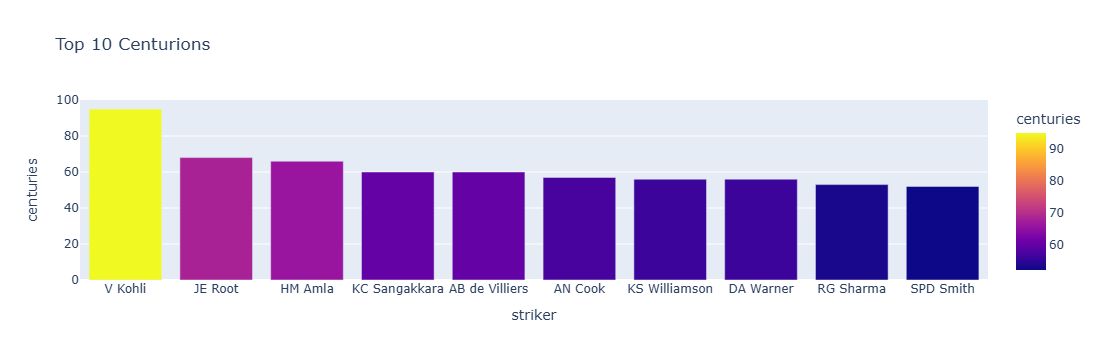

In [60]:
query3 = """
SELECT striker, COUNT(*) AS centuries
FROM (
    SELECT match_id, striker, SUM(runs_batter) AS runs
    FROM deliveries
    GROUP BY match_id, striker
    HAVING runs >= 100
)
GROUP BY striker
ORDER BY centuries DESC
LIMIT 10;
"""
df = pd.read_sql(query3, engine)

px.bar(df, x="striker", y="centuries", title="Top 10 Centurions", color="centuries")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\3657478164.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




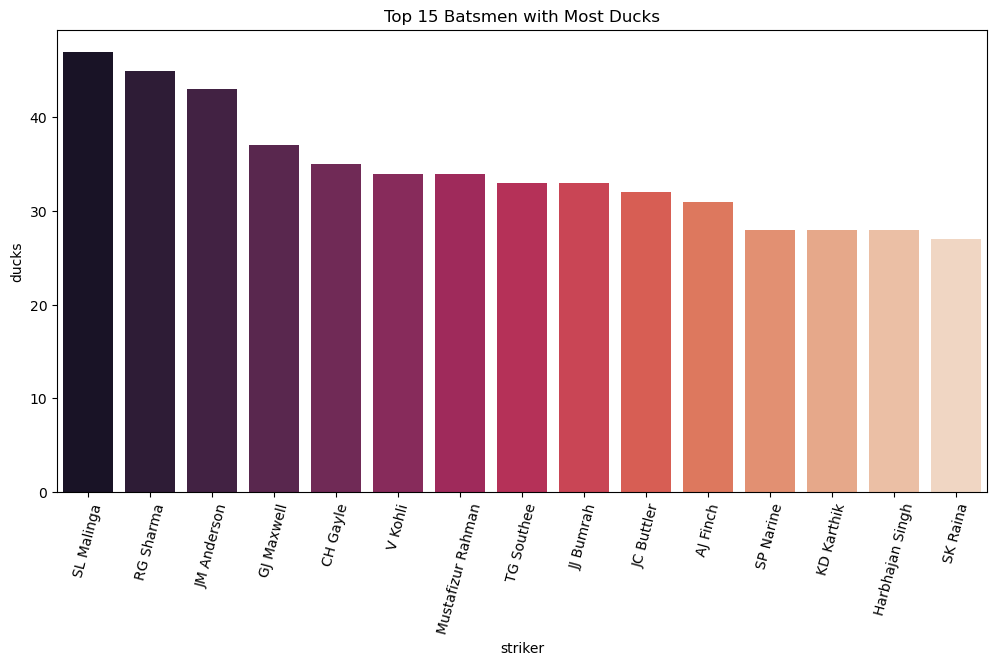

In [61]:
query3 = """
SELECT striker, COUNT(*) AS ducks
FROM (
    SELECT match_id, striker, SUM(runs_batter) AS runs
    FROM deliveries
    GROUP BY match_id, striker
    HAVING runs = 0
)
GROUP BY striker
ORDER BY ducks DESC
LIMIT 15;
"""
df = pd.read_sql(query3, engine)

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="striker", y="ducks", palette="rocket")
plt.xticks(rotation=75)
plt.title("Top 15 Batsmen with Most Ducks")
plt.show()


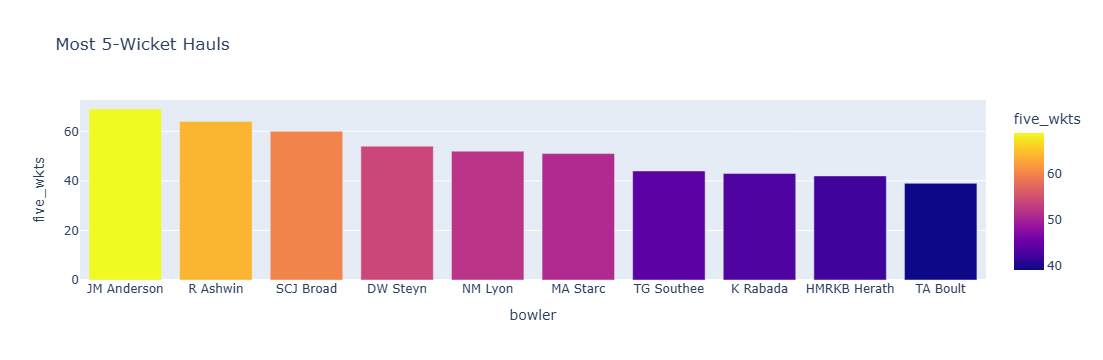

In [62]:
query4 = """
SELECT bowler, COUNT(*) AS five_wkts
FROM (
    SELECT match_id, bowler, COUNT(*) AS wkts
    FROM deliveries
    WHERE wicket_kind IS NOT NULL
    GROUP BY match_id, bowler
    HAVING wkts >= 5
)
GROUP BY bowler
ORDER BY five_wkts DESC
LIMIT 10;
"""
df = pd.read_sql(query4, engine)

px.bar(df, x="bowler", y="five_wkts", title="Most 5-Wicket Hauls", color="five_wkts")


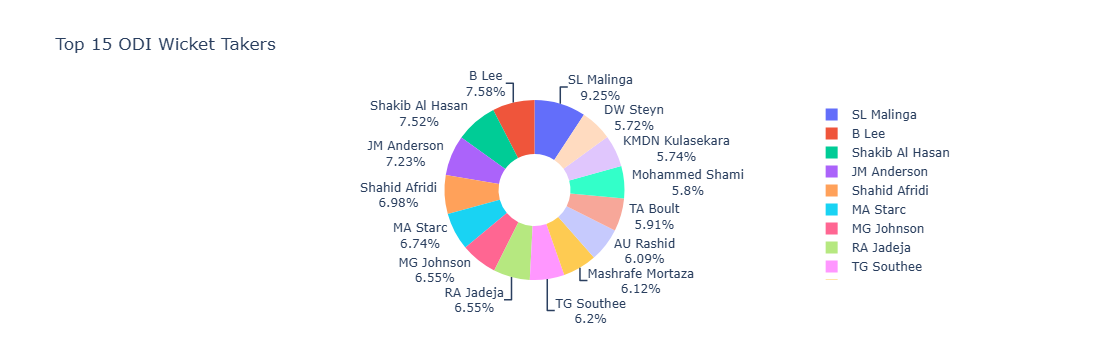

In [63]:
query5 = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='ODI' AND wicket_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 15;
"""
df = pd.read_sql(query5, engine)

fig = px.pie(
    df,
    names="bowler", 
    values="wickets", 
    title="Top 15 ODI Wicket Takers",
    hole=0.4  # use 0 for normal pie, 0.4 for donut style
)
fig.update_traces(textinfo="percent+label")  # show % and name
fig.show()



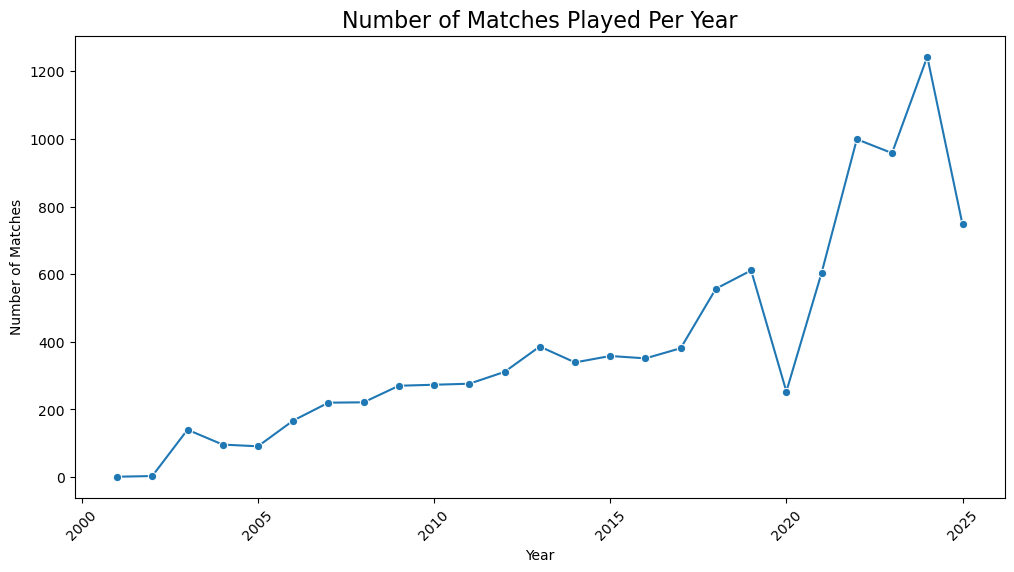

In [52]:
# Convert date to datetime if not already query 6
matches_df = pd.read_sql_query("SELECT date FROM matches;", conn)
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')
matches_df['year'] = matches_df['date'].dt.year
 
# Count matches per year
matches_per_year = matches_df.groupby('year').size().reset_index(name='matches')
 
# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='matches', data=matches_per_year, marker='o')
plt.title("Number of Matches Played Per Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\3731190683.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




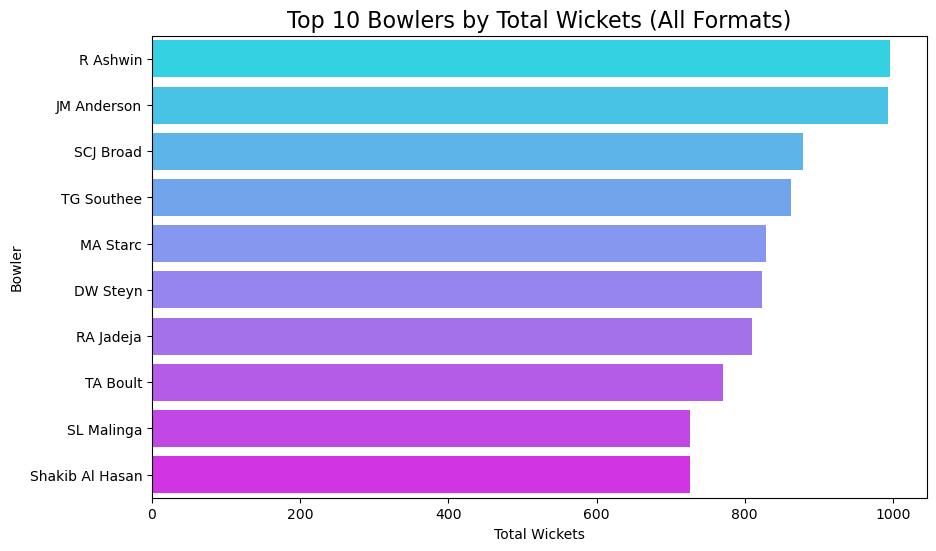

In [64]:
# Query to fetch top bowlers by wickets across all formats
query7 = """
SELECT bowler,
       COUNT(*) AS total_wickets
FROM deliveries d
WHERE player_out IS NOT NULL
GROUP BY bowler
ORDER BY total_wickets DESC
LIMIT 10;
"""
 
df = pd.read_sql_query(query7, conn)
 
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="total_wickets", y="bowler", data=df, palette="cool")
plt.title("Top 10 Bowlers by Total Wickets (All Formats)", fontsize=16)
plt.xlabel("Total Wickets")
plt.ylabel("Bowler")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\3734506692.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




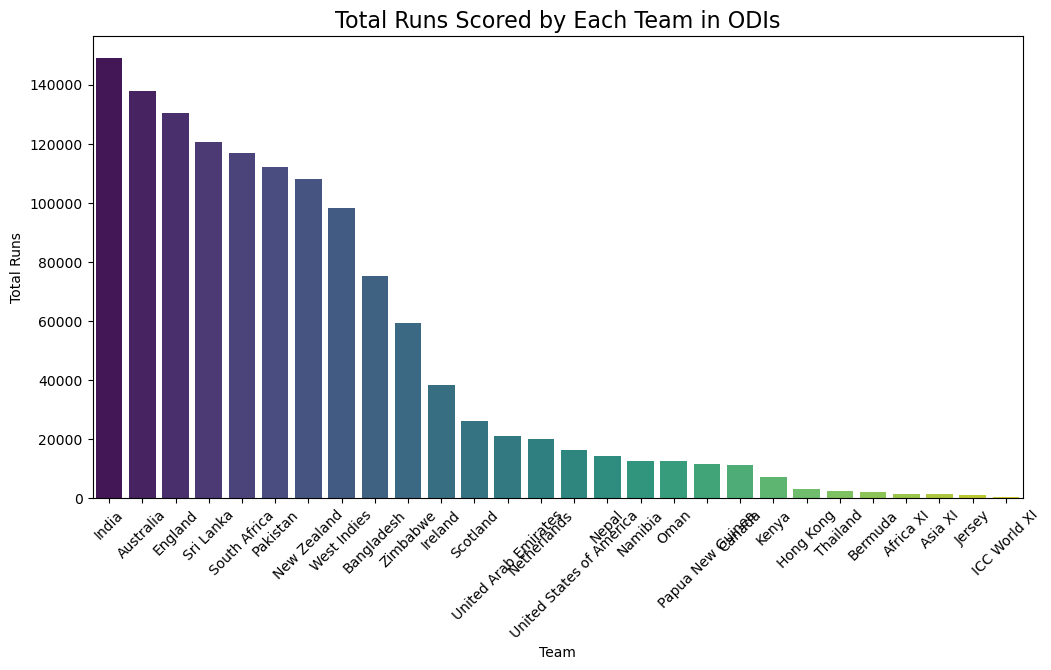

In [65]:
# Query to fetch total runs by each team in ODIs
query8 = """
SELECT batting_team AS team,
       SUM(runs_total) AS total_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY batting_team
ORDER BY total_runs DESC;
"""
 
df = pd.read_sql_query(query8, conn)
 
# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="team", y="total_runs", data=df, palette="viridis")
plt.title("Total Runs Scored by Each Team in ODIs", fontsize=16)
plt.xlabel("Team")
plt.ylabel("Total Runs")
plt.xticks(rotation=45)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11796\4031224672.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




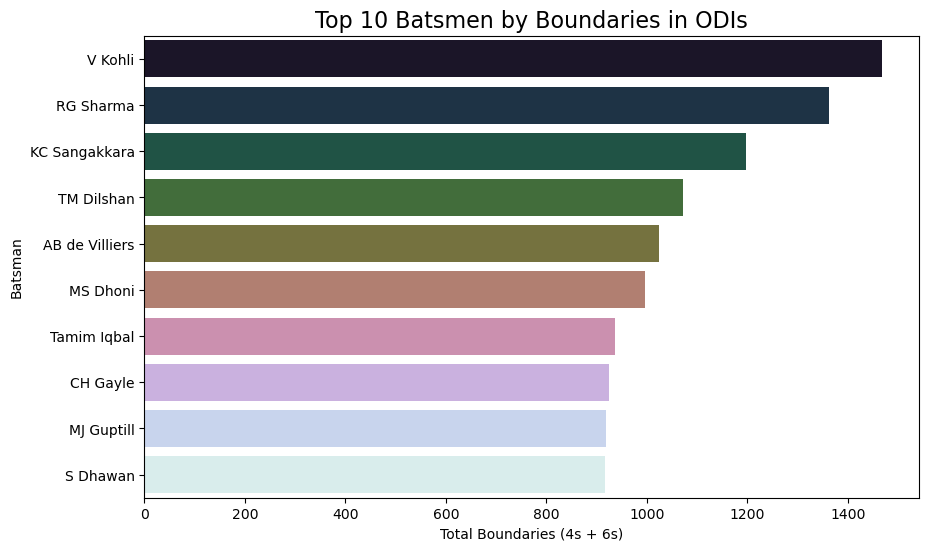

In [66]:
# Query to fetch top batsmen by boundaries
query9 = """
SELECT striker AS batsman,
       SUM(is_boundary_4 + is_boundary_6) AS total_boundaries
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY total_boundaries DESC
LIMIT 10;
"""
 
df = pd.read_sql_query(query9, conn)
 
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="total_boundaries", y="batsman", data=df, palette="cubehelix")
plt.title("Top 10 Batsmen by Boundaries in ODIs", fontsize=16)
plt.xlabel("Total Boundaries (4s + 6s)")
plt.ylabel("Batsman")
plt.show()

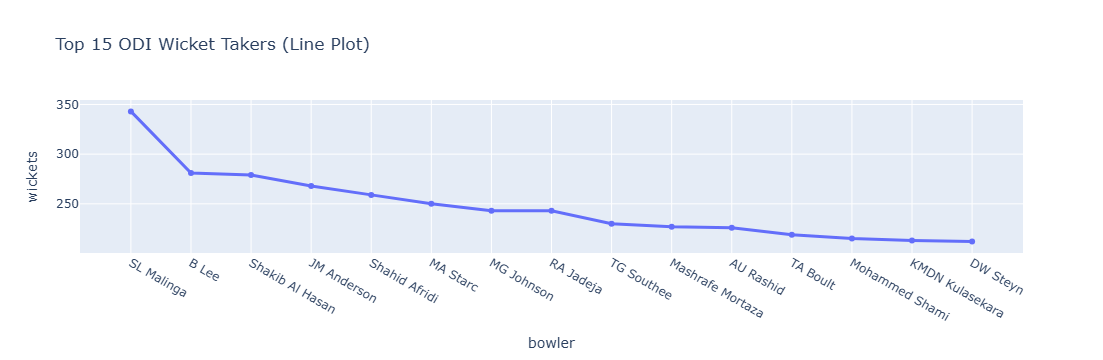

In [67]:
query10 = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='ODI' AND wicket_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 15;
"""
df = pd.read_sql(query10, engine)

fig = px.line(
    df,
    x="bowler",
    y="wickets",
    title="Top 15 ODI Wicket Takers (Line Plot)",
    markers=True  # adds points for each bowler
)
fig.update_traces(line=dict(width=3))  # make line thicker
fig.show()


In [2]:
import sqlite3
import pandas as pd
 
# Connect to SQLite DB (or MySQL if you use MySQL)
conn = sqlite3.connect("cricsheet.db")

In [ ]:
# Matches table
df_matches = pd.read_sql_query("SELECT * FROM matches;", conn)
 
# Deliveries table
df_deliveries = pd.read_sql_query("SELECT * FROM deliveries;", conn)

In [ ]:
df_matches.head()
df_deliveries.head()

In [7]:
df_matches.to_csv("matches.csv", index=False)
df_deliveries.to_csv("deliveries.csv", index=False)

In [8]:
import os
print(os.getcwd())

C:\Users\Lenovo\Cricsheet_Match_Analysis


In [9]:
print(os.path.exists("matches.csv"))
print(os.path.exists("deliveries.csv"))

True
True


In [11]:
pd.read_csv("matches.csv").head()
pd.read_csv("deliveries.csv").head()

,match_id,innings_no,over_no,ball_in_over,batting_team,bowling_team,striker,non_striker,bowler,runs_batter,runs_extras,runs_total,wicket_kind,player_out,is_boundary_4,is_boundary_6
0,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
1,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
2,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,4,0,4,NaN,NaN,1,0
3,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
4,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,2,2,NaN,NaN,0,0
